<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Task-statistics" data-toc-modified-id="Task-statistics-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Task statistics</a></span></li><li><span><a href="#Train-model" data-toc-modified-id="Train-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train model</a></span><ul class="toc-item"><li><span><a href="#Evaluate-performance" data-toc-modified-id="Evaluate-performance-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Evaluate performance</a></span></li></ul></li><li><span><a href="#Ratemaps" data-toc-modified-id="Ratemaps-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Ratemaps</a></span><ul class="toc-item"><li><span><a href="#Grid-scores" data-toc-modified-id="Grid-scores-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Grid scores</a></span></li></ul></li><li><span><a href="#Manifold-distance" data-toc-modified-id="Manifold-distance-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Manifold distance</a></span></li><li><span><a href="#Neural-sheet" data-toc-modified-id="Neural-sheet-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Neural sheet</a></span></li><li><span><a href="#Connectivity" data-toc-modified-id="Connectivity-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Connectivity</a></span><ul class="toc-item"><li><span><a href="#Sort-weights" data-toc-modified-id="Sort-weights-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Sort weights</a></span></li></ul></li><li><span><a href="#Path-integration" data-toc-modified-id="Path-integration-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Path integration</a></span></li><li><span><a href="#SVD" data-toc-modified-id="SVD-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>SVD</a></span></li><li><span><a href="#Null-model-(low-pass-filtered-noise)" data-toc-modified-id="Null-model-(low-pass-filtered-noise)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Null model (low-pass filtered noise)</a></span></li><li><span><a href="#Boundary-extension" data-toc-modified-id="Boundary-extension-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Boundary extension</a></span></li><li><span><a href="#Head-direction-and-speed-tuning" data-toc-modified-id="Head-direction-and-speed-tuning-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Head direction and speed tuning</a></span></li><li><span><a href="#Border-score" data-toc-modified-id="Border-score-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Border score</a></span></li></ul></div>

In [1]:
import numpy as np
import torch

from tqdm import tqdm
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
# If GPUs available, select which to train on
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
from utils import generate_run_ID, load_trained_weights
from place_cells import PlaceCells
from trajectory_generator import TrajectoryGenerator
from model import RNN, Transformer
from trainer import Trainer

/Users/julianyocum/anaconda3/envs/ganguli/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Training options and hyperparameters
class Options:
    pass
options = Options()

options.save_dir = '/Users/julianyocum/Projects/grid-pattern-formation/models/'
options.n_steps = 5000      # number of training steps
options.batch_size = 100      # number of trajectories per batch
options.sequence_length = 20  # number of steps in trajectory
options.learning_rate = 1e-4  # gradient descent learning rate
options.Np = 512              # number of place cells
options.Ng = 4096             # number of grid cells
options.place_cell_rf = 0.12  # width of place cell center tuning curve (m)
options.surround_scale = 2    # if DoG, ratio of sigma2^2 to sigma1^2
options.RNN_type = 'Transformer'      # RNN or LSTM
options.activation = 'relu'   # recurrent nonlinearity
options.weight_decay = 0   # strength of weight decay on recurrent weights
options.DoG = True            # use difference of gaussians tuning curves
options.periodic = False      # trajectories with periodic boundary conditions
options.box_width = 2.2       # width of training environment
options.box_height = 2.2      # height of training environment

# added
options.device = 'mps'

options.run_ID = generate_run_ID(options)

In [5]:
# If you've trained with these params before, will restore trained model
place_cells = PlaceCells(options)
if options.RNN_type == 'RNN':
    model = RNN(options, place_cells).to(options.device)
elif options.RNN_type == 'Transformer':
    model = Transformer(options, place_cells).to(options.device)
trajectory_generator = TrajectoryGenerator(options, place_cells)
trainer = Trainer(options, model, trajectory_generator)

# Load example weights stored on github
# weight_dir = options.save_dir + '/example_trained_weights.npy'
# load_trained_weights(model, trainer, weight_dir)

Restored trained model from /Users/julianyocum/Projects/grid-pattern-formation/models/Transformer_steps_5000_sequence_20_batch_100_4096_relu_rf_012_DoG_True_periodic_False_lr_00001_weight_decay_0/most_recent_model.pth


# Task statistics

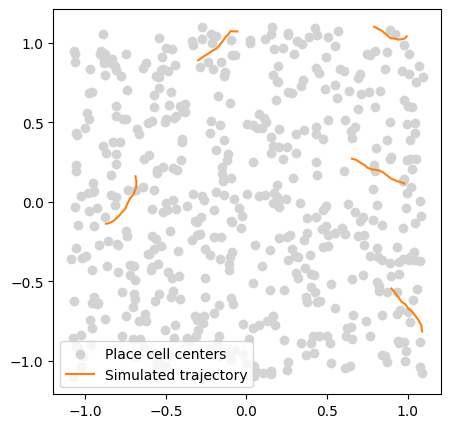

In [6]:
# Plot a few sample trajectories
inputs, pos, pc_outputs = trajectory_generator.get_test_batch()
us = place_cells.us.cpu()
pos = pos.cpu()

plt.figure(figsize=(5,5))
plt.scatter(us[:,0], us[:,1], c='lightgrey', label='Place cell centers')
for i in range(5):
    plt.plot(pos[:,i,0],pos[:,i,1], label='Simulated trajectory', c='C1')
    if i==0:
        plt.legend();

In [7]:
inputs[0].shape, inputs[1].shape, pc_outputs.shape

(torch.Size([20, 100, 2]), torch.Size([100, 512]), torch.Size([20, 100, 512]))

In [8]:
pc_outputs.shape

torch.Size([20, 100, 512])

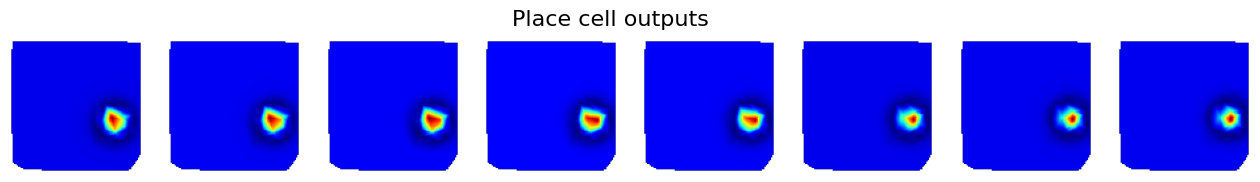

In [9]:
# Plot a few place cell outputs
pc_outputs = pc_outputs.reshape(-1, options.Np).detach().cpu()
pc = place_cells.grid_pc(pc_outputs[::100], res=100)

plt.figure(figsize=(16,2))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(pc[i], cmap='jet')
    plt.axis('off')
        
plt.suptitle('Place cell outputs', fontsize=16)
plt.show()

# plt.tight_layout()

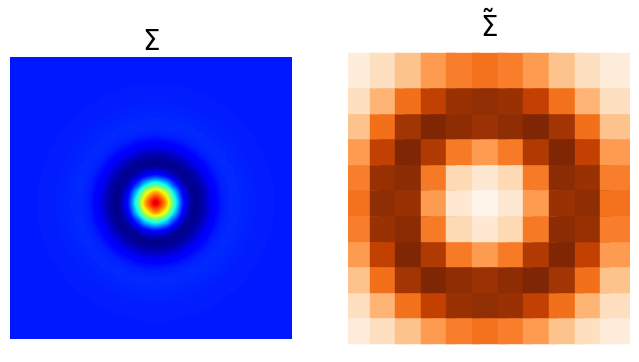

In [10]:
# Visualize place cell covariance matrix
Cmean = place_cells.compute_covariance(res=30)

# Fourier transform
Ctilde = np.fft.fft2(Cmean)
Ctilde[0,0] = 0

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(Cmean, cmap='jet', interpolation='gaussian')
plt.axis('off')
plt.title(r'$\Sigma$', fontsize=20)

plt.subplot(122)
width = 6
idxs = np.arange(-width+1, width)
x2, y2 = np.meshgrid(np.arange(2*width-1), np.arange(2*width-1))
plt.scatter(x2,y2,c=np.abs(Ctilde)[idxs][:,idxs],
            s=600, cmap='Oranges', marker='s')

plt.axis('equal')
plt.axis('off')
plt.title(r'$\tilde \Sigma$', fontsize=20)
plt.axis('off');

# Train model

In [11]:
# trainer.train(n_steps=options.n_steps, n_epochs=1, save=True)

# plt.figure(figsize=(12,3))
# plt.subplot(121)
# plt.plot(trainer.err, c='black')

# plt.title('Decoding error (m)'); plt.xlabel('train step')
# plt.subplot(122)
# plt.plot(trainer.loss, c='black');
# plt.title('Loss'); plt.xlabel('train step');

## Evaluate performance

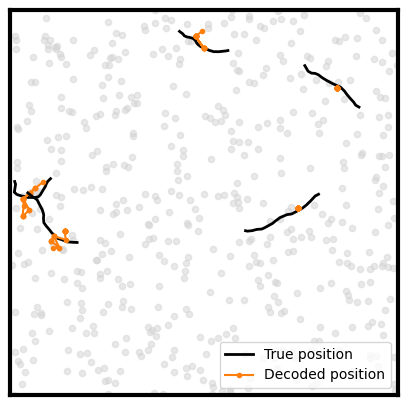

In [12]:
inputs, pos, pc_outputs = trajectory_generator.get_test_batch()
pos = pos.cpu()
pred_pos = place_cells.get_nearest_cell_pos(model.predict(inputs)).cpu()
us = place_cells.us.cpu()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
for i in range(5):
    plt.plot(pos[:,i,0], pos[:,i,1], c='black', label='True position', linewidth=2)
    plt.plot(pred_pos[:,i,0], pred_pos[:,i,1], '.-',
             c='C1', label='Decoded position')
    if i==0:
        plt.legend()
plt.scatter(us[:,0], us[:,1], s=20, alpha=0.5, c='lightgrey')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
plt.xticks([])
plt.yticks([])
plt.xlim([-options.box_width/2,options.box_width/2])
plt.ylim([-options.box_height/2,options.box_height/2]);
# plt.savefig('images/sim_traj_decode.pdf')

In [13]:
# pos[:,1,:], pred_pos[:,1,:]

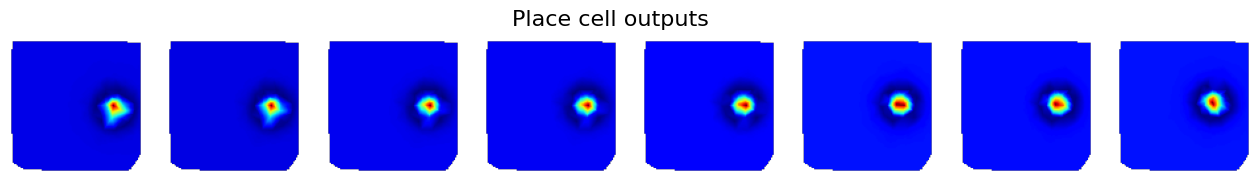

In [14]:
# Plot a few place cell outputs
pc_outputs = pc_outputs.reshape(-1, options.Np).detach().cpu()
pc = place_cells.grid_pc(pc_outputs[::100], res=100)

plt.figure(figsize=(16,2))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(pc[i], cmap='jet')
    plt.axis('off')
        
plt.suptitle('Place cell outputs', fontsize=16)
plt.show()

# plt.tight_layout()

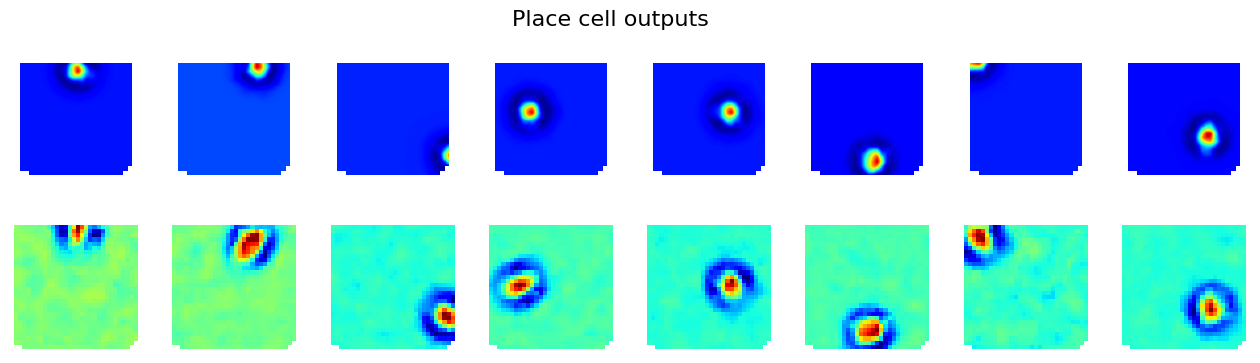

In [15]:
# Visualize predicted place cell outputs
inputs, pos, pc_outputs = trajectory_generator.get_test_batch()
preds = model.predict(inputs)
preds = preds.reshape(-1, options.Np).detach().cpu()
pc_outputs = model.softmax(pc_outputs).reshape(-1, options.Np).cpu()
pc_pred = place_cells.grid_pc(preds[:100])
pc = place_cells.grid_pc(pc_outputs[:100])

plt.figure(figsize=(16,4))
for i in range(8):
    plt.subplot(2,8,i+9)
    plt.imshow(pc_pred[2*i], cmap='jet')
    if i==0:
        plt.ylabel('Predicted')
    plt.axis('off')
    
for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(pc[2*i], cmap='jet', interpolation='gaussian')
    if i==0:
        plt.ylabel('True')
    plt.axis('off')
    
plt.suptitle('Place cell outputs', fontsize=16)
plt.show()

# Ratemaps

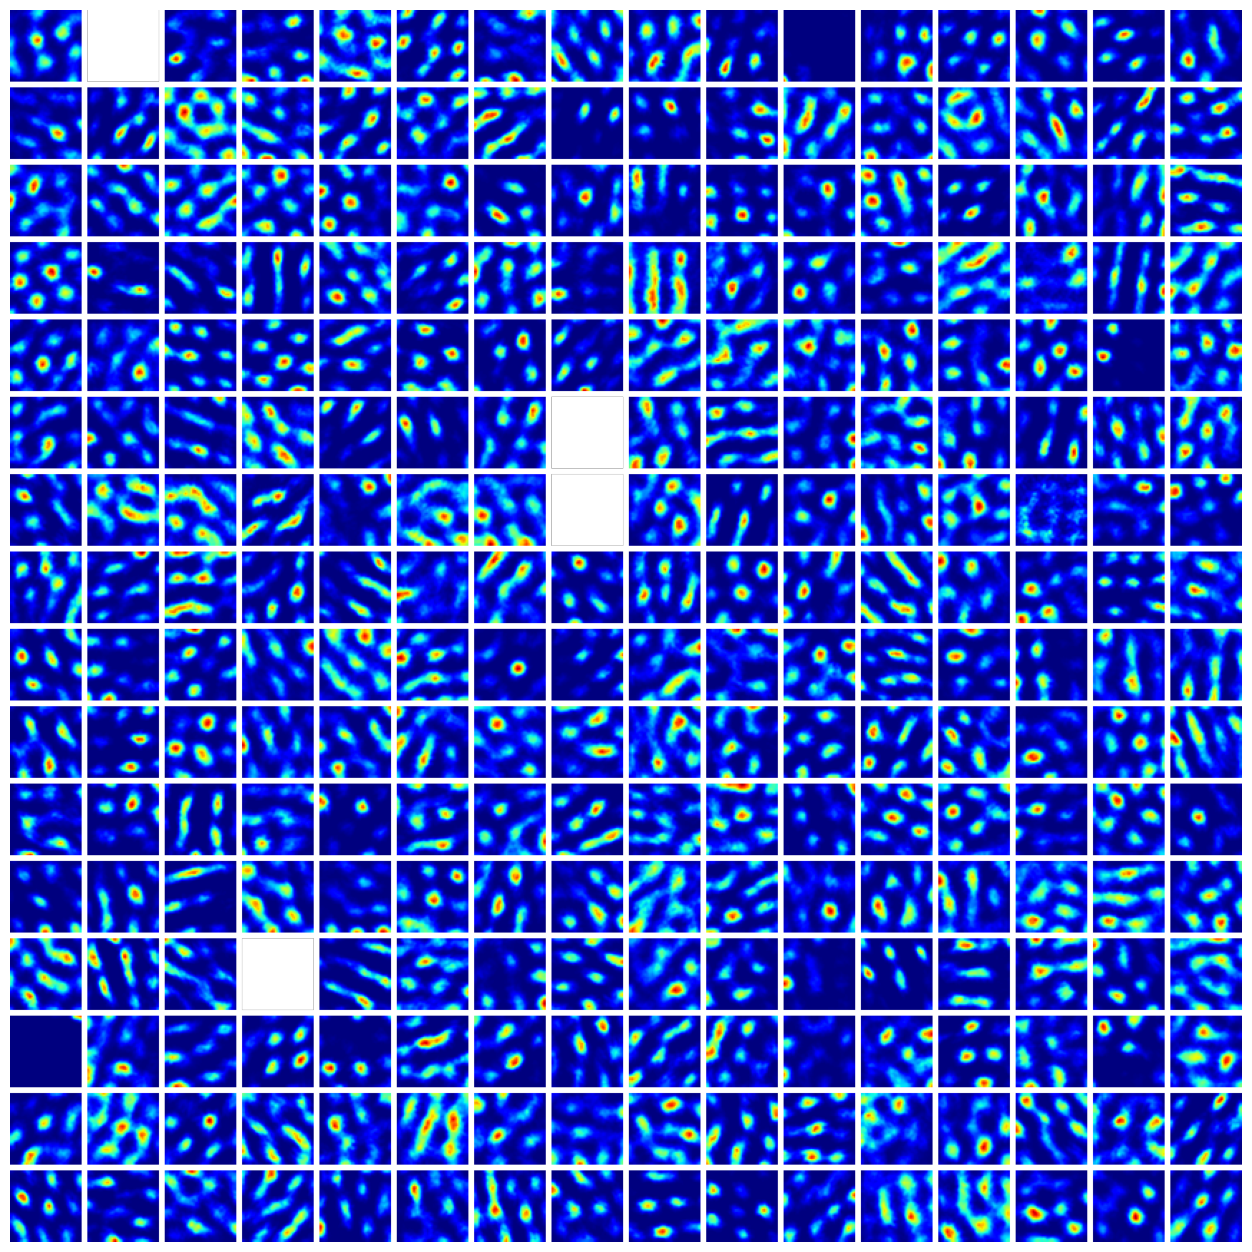

In [16]:
from visualize import compute_ratemaps, plot_ratemaps
res = 50
n_avg = 100
Ng = options.Ng
activations, rate_map, g, pos = compute_ratemaps(model,
                                                 trajectory_generator,
                                                 options,
                                                 res=res,
                                                 n_avg=n_avg,
                                                 Ng=Ng)

# Compute a set of lo-res maps to use for evalutaing grid score
lo_res = 20
_, rate_map_lores, _, _ = compute_ratemaps(model,
                                         trajectory_generator,
                                         options,
                                         res=lo_res,
                                         n_avg=n_avg,
                                         Ng=Ng)
n_plot = 256
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations, n_plot, smooth=True)
plt.imshow(rm_fig)
plt.axis('off');

In [17]:
from scores import GridScorer

starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)
box_width=options.box_width
box_height=options.box_height
coord_range=((-box_width/2, box_width/2), (-box_height/2, box_height/2))
masks_parameters = zip(starts, ends.tolist())
scorer = GridScorer(lo_res, coord_range, masks_parameters)

score_60, score_90, max_60_mask, max_90_mask, sac, max_60_ind = zip(
      *[scorer.get_scores(rm.reshape(lo_res, lo_res)) for rm in tqdm(rate_map_lores)])

100%|██████████| 4096/4096 [00:25<00:00, 159.07it/s]


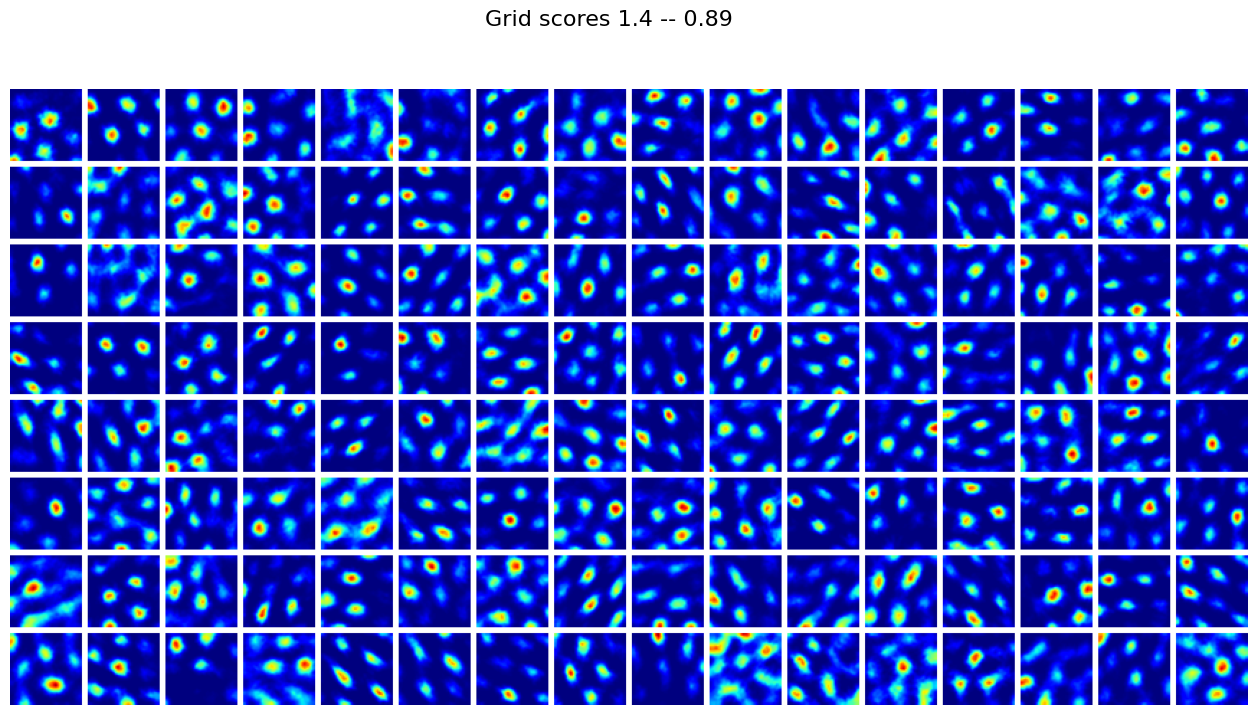

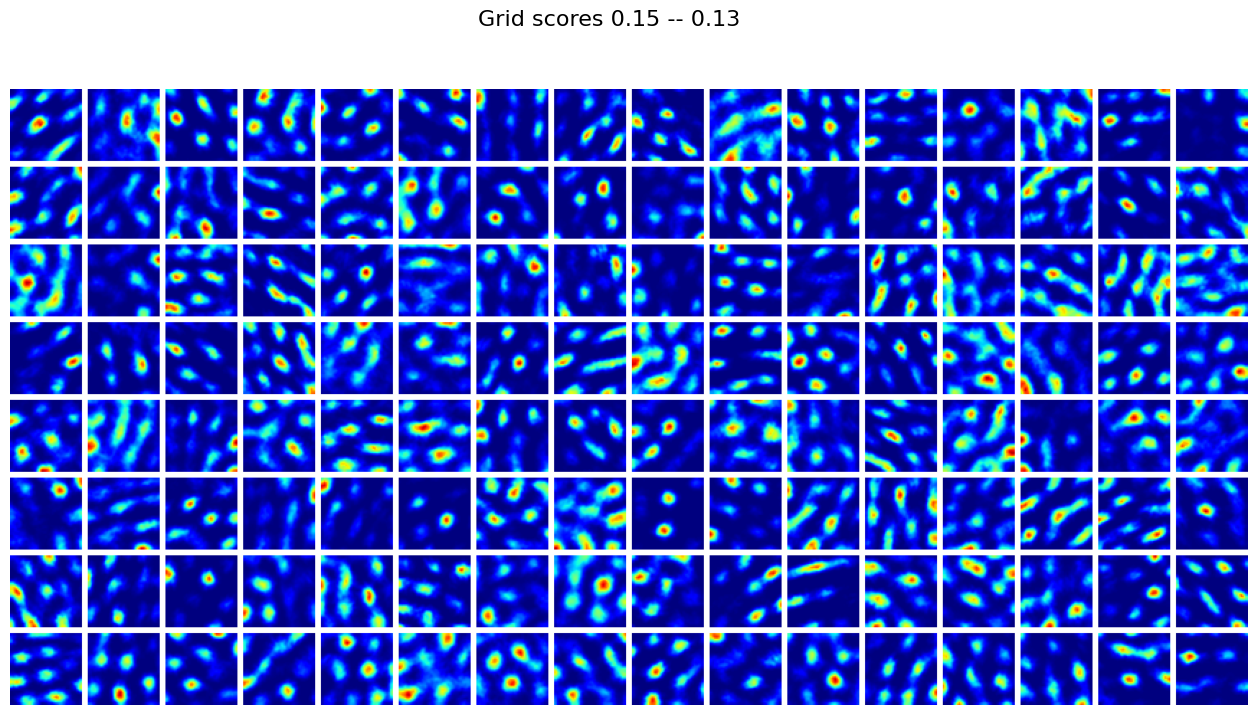

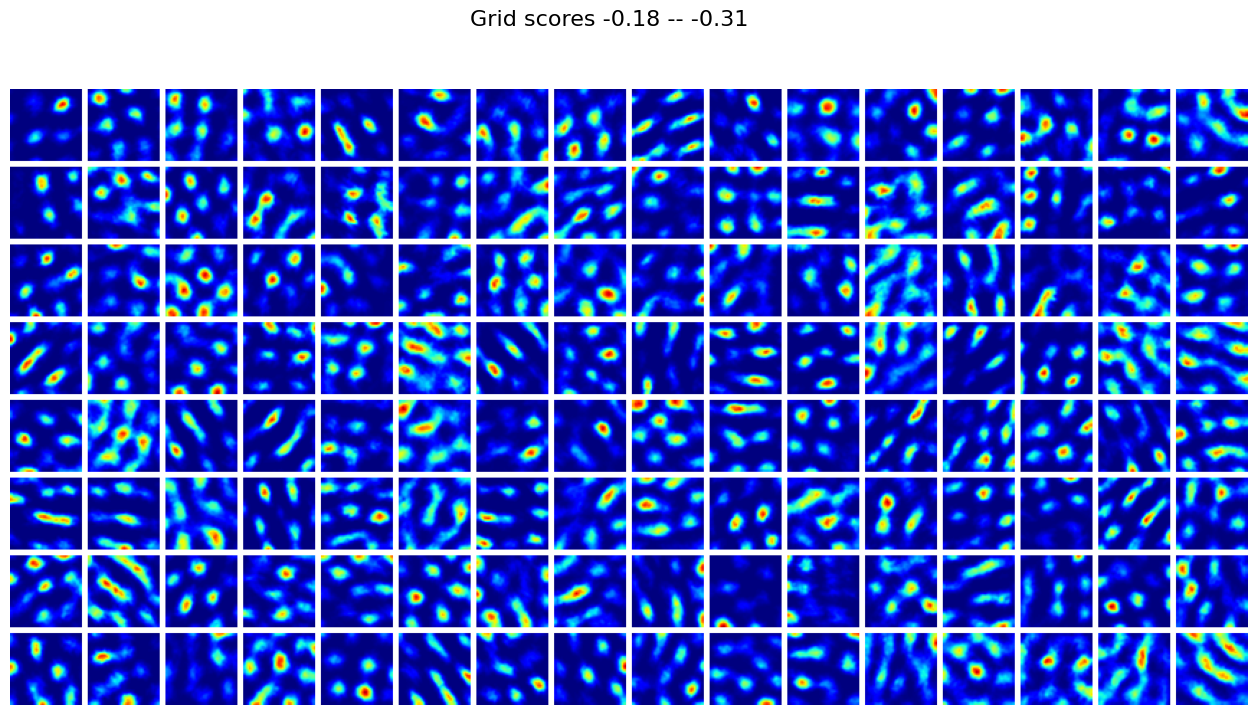

In [18]:
idxs = np.flip(np.argsort(score_60))
Ng = options.Ng

# Plot high grid scores
n_plot = 128
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[idxs], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores '+str(np.round(score_60[idxs[0]], 2))
             +' -- '+ str(np.round(score_60[idxs[n_plot]], 2)),
            fontsize=16)
plt.axis('off');

# Plot medium grid scores
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[idxs[Ng//4:]], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores '+str(np.round(score_60[idxs[Ng//2]], 2))
             +' -- ' + str(np.round(score_60[idxs[Ng//2+n_plot]], 2)),
            fontsize=16)
plt.axis('off');

# Plot low grid scores
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[np.flip(idxs)], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores '+str(np.round(score_60[idxs[-n_plot]], 2))
             +' -- ' + str(np.round(score_60[idxs[-1]], 2)),
            fontsize=16)
plt.axis('off');

# Manifold distance

In [19]:
activations.shape, rate_map.shape, g.shape

((4096, 50, 50), (4096, 2500), (200000, 4096))

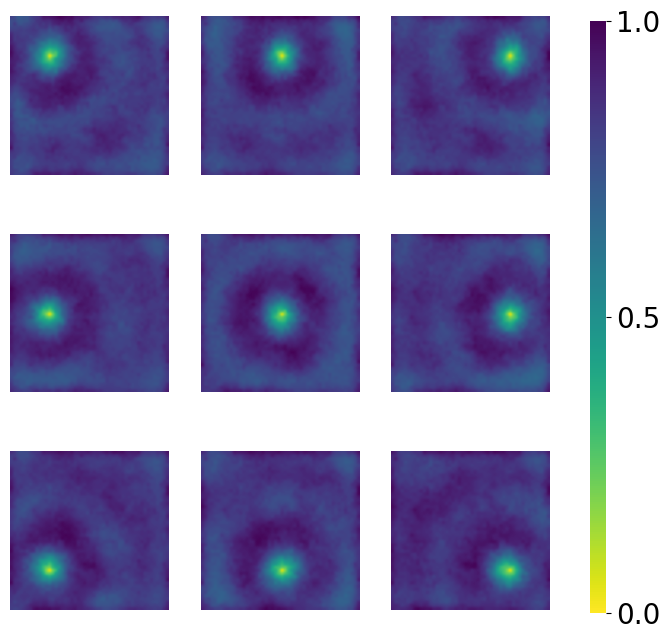

In [20]:
# Keeping all grid cells
origins = np.stack(np.mgrid[:3,:3] - 1) * res//4 + res//2

fig = plt.figure(figsize=(8,8))
for i in range(3):
    for j in range(3):
        plt.subplot(3,3,3*i+j+1)
        origin=np.random.randint(0,100,2)
        origin_idx = np.ravel_multi_index((origins[0,i,j],origins[1,i,j]), (res,res))
        r0 = rate_map[:,origin_idx,None]
        dists = np.linalg.norm(r0 - rate_map, axis=0)
        im = plt.imshow(dists.reshape(res,res)/np.max(dists),
                        cmap='viridis_r', interpolation='gaussian')
        plt.axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.12, 0.02, 0.74])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.locator_params(nbins=3)
cbar.ax.tick_params(labelsize=20) 
cbar.outline.set_visible(False)

Text(0.5, 0.98, 'Manifold Distance. Top 50')

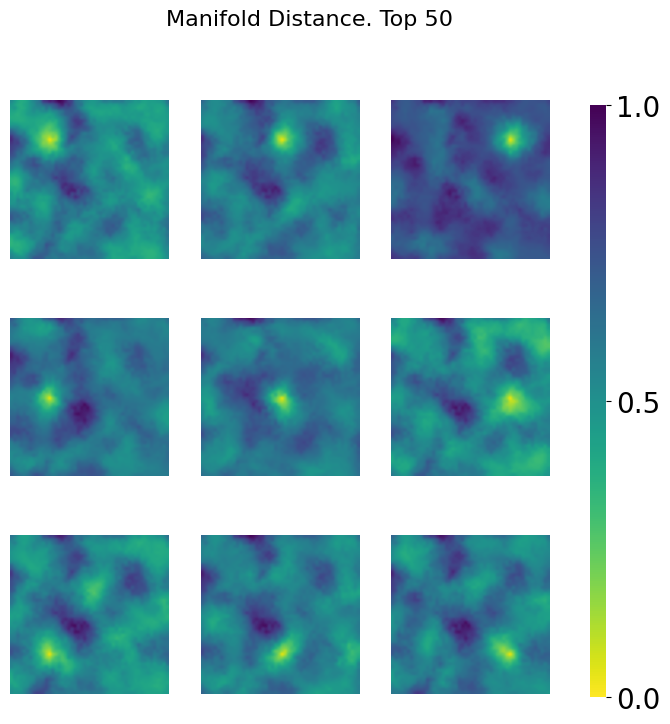

In [21]:
# Keeping only top 500 grid cells
n_grid_cells = 50
grid_sort = np.flip(np.argsort(score_60))
origins = np.stack(np.mgrid[:3,:3] - 1) * res//4 + res//2

fig = plt.figure(figsize=(8,8))
for i in range(3):
    for j in range(3):
        plt.subplot(3,3,3*i+j+1)
        origin=np.random.randint(0,100,2)
        origin_idx = np.ravel_multi_index((origins[0,i,j],origins[1,i,j]), (res,res))
        r0 = rate_map[grid_sort[:n_grid_cells],origin_idx,None]
        dists = np.linalg.norm(r0 - rate_map[grid_sort[:n_grid_cells]], axis=0)
        im = plt.imshow(dists.reshape(res,res)/np.max(dists),
                        cmap='viridis_r', interpolation='gaussian')
        plt.axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.12, 0.02, 0.74])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.locator_params(nbins=3)
cbar.ax.tick_params(labelsize=20) 
cbar.outline.set_visible(False)
plt.suptitle(f'Manifold Distance. Top {n_grid_cells}', fontsize=16)

In [22]:
r0 = rate_map[grid_sort[:n_grid_cells],:]
r0.shape

(50, 2500)

# Neural sheet

In [23]:
# Fourier transform 
Ng = options.Ng
rm_fft_real = np.zeros([Ng,res,res])
rm_fft_imag = np.zeros([Ng,res,res])

for i in tqdm(range(Ng)):
    rm_fft_real[i] = np.real(np.fft.fft2(rate_map[i].reshape([res,res])))
    rm_fft_imag[i] = np.imag(np.fft.fft2(rate_map[i].reshape([res,res])))
    
rm_fft = rm_fft_real + 1j * rm_fft_imag

100%|██████████| 4096/4096 [00:00<00:00, 19179.61it/s]


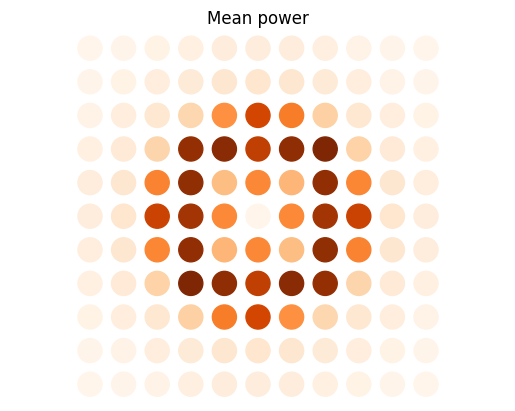

In [24]:
width = 6
idxs = np.arange(-width+1, width)
x2, y2 = np.meshgrid(np.arange(2*width-1), np.arange(2*width-1))
im = (np.real(rm_fft)**2).mean(0)
im[0,0] = 0
plt.scatter(x2,y2,c=im[idxs][:,idxs], s=300, cmap='Oranges')
plt.axis('equal')
plt.axis('off');
plt.title('Mean power');

In [25]:
idxs

array([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5])

In [26]:
k1 = [3,0]   # Horizontal component
k2 = [2,3]   # 60° component
k3 = [-1,3]  # 120° component

k1 = [-2,2]
k2 = [3,0]
k3 = [-1,-3]

k4=k5=k6=k1  # Additional copies (possibly for analysis)

freq = 1
ks = freq*np.array([k1,k2,k3,k4,k5,k6])
ks = ks.astype('int')

modes = np.stack([rm_fft[:,k[0],k[1]] for k in ks])

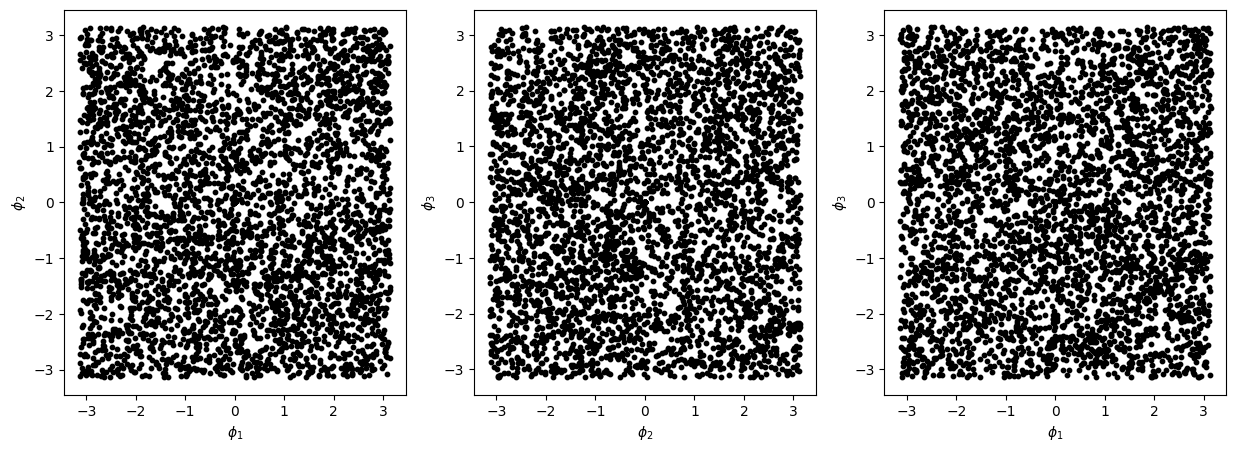

In [27]:
# Find phases
phases = [np.angle(mode) for mode in modes]

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(phases[0], phases[1], c='black', s=10)
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')
plt.subplot(132)
plt.scatter(phases[1], phases[2], c='black', s=10)
plt.xlabel(r'$\phi_2$')
plt.ylabel(r'$\phi_3$')
plt.subplot(133)
plt.scatter(phases[0], phases[2], c='black', s=10)
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_3$')
plt.show()

Text(0.5, 0, '$\\phi_3$')

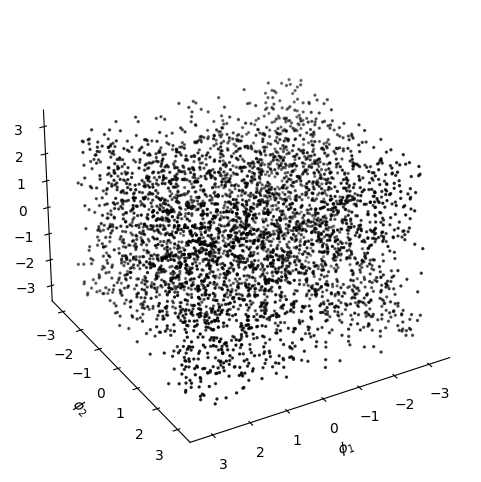

In [28]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(phases[0], phases[1], phases[2], c='black', s=2)
ax.view_init(azim=60)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_2$')
ax.set_zlabel(r'$\phi_3$')

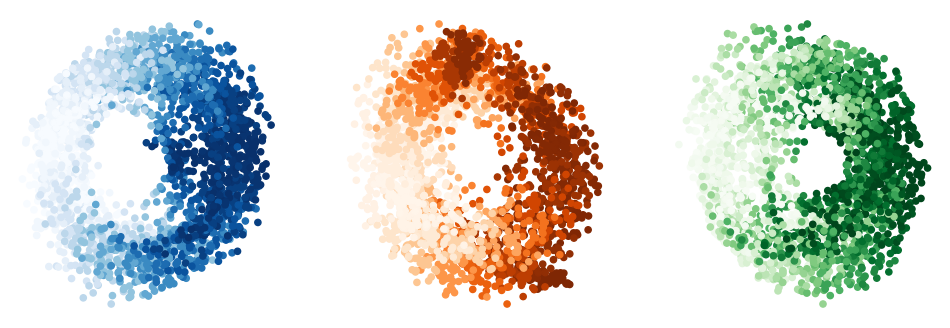

In [29]:
freq = 1
crop = 0
cmaps = ['Blues', 'Oranges', 'Greens']
x = np.mgrid[:res,:res] * 2*np.pi/ res
x = x.reshape(2, -1)
k = freq*np.stack([k1,k2,k3])
X = np.concatenate([np.cos(k.dot(x)), np.sin(k.dot(x))], axis=0)
idxs1, idxs2 = np.mgrid[crop:res-crop, crop:res-crop]
idxs = np.ravel_multi_index((idxs1,idxs2), (res,res)).ravel()

plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    B = np.stack([np.cos(phases[i]), np.sin(phases[i])])
    test = B@rate_map
    plt.scatter(test[0], test[1], c=X[i][idxs], cmap=cmaps[i], s=20)
    plt.axis('off')

In [30]:
import scipy
X = rate_map - rate_map.mean(-1,keepdims=True)
X -= X.mean(-1, keepdims=True)
Ua, S, V = scipy.linalg.svd(X)

rm_embed = Ua.T@rate_map

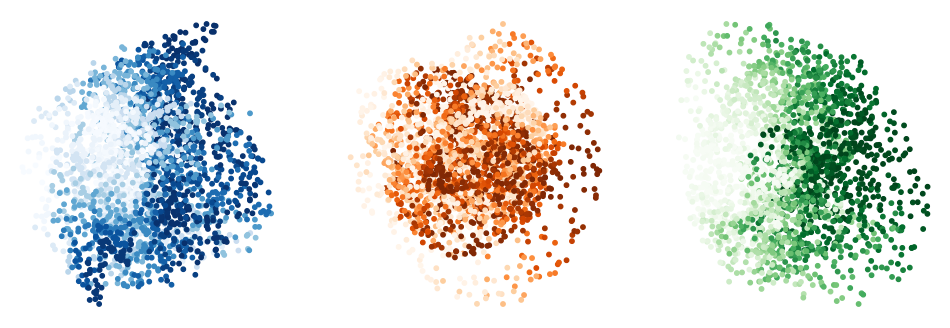

In [31]:
# Construct torus
# k1 = [1,0]
# k2 = [0.5, 0.5*np.sqrt(3)]
# k3 = np.array([-0.5, 0.5*np.sqrt(3)]) 

k1 = [3,0]
k2 = [2,2.5]
k3 = [-1,2.3]

# k1 = [1,0]
# k2 = [2,2.5]
# k3 = [-1,2.3]

freq = 1
x = np.mgrid[:res,:res] * 2*np.pi/ res
x = x.reshape(2, -1)
k = freq*np.stack([k1,k2,k3])
X = np.concatenate([np.cos(k.dot(x)), np.sin(k.dot(x))], axis=0)
cmaps = ['Blues', 'Oranges', 'Greens']

crop = 0
idxs1, idxs2 = np.mgrid[crop:res-crop, crop:res-crop]
idxs = np.ravel_multi_index((idxs1,idxs2), (res,res)).ravel()

# Find rotation
RM = rm_embed[:10, idxs]
X_crop = X[:,idxs]
R = np.linalg.inv(RM.dot(RM.T)).dot(RM).dot(X_crop.T).T

# Lowdin symmetric orthogonalization 
U,s,V = np.linalg.svd(R)
S2 = U.dot(np.diag(1./s)).dot(U.T)
R = S2.dot(R)

# Plot rings
plt.figure(figsize=(12,4))
for i in range(R.shape[0]//2):
    plt.subplot(1,3,i+1)
    plt.scatter(R.dot(RM)[i], R.dot(RM)[i+3], c=X[i][idxs], cmap=cmaps[i], s=10)
    plt.axis('off')
    
# plt.savefig(folder + 'ring_fit.png')

In [32]:
top_n_rate_map = rate_map[grid_sort[:100],:]
top_n_rate_map.shape

(100, 2500)

In [36]:
rate_map.shape

(4096, 2500)

Applying PCA to reduce dimensions from 4096 to 6...
Explained variance with 6 components: 40.13%
Applying UMAP to create 3D visualization...


/Users/julianyocum/anaconda3/envs/ganguli/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/julianyocum/anaconda3/envs/ganguli/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



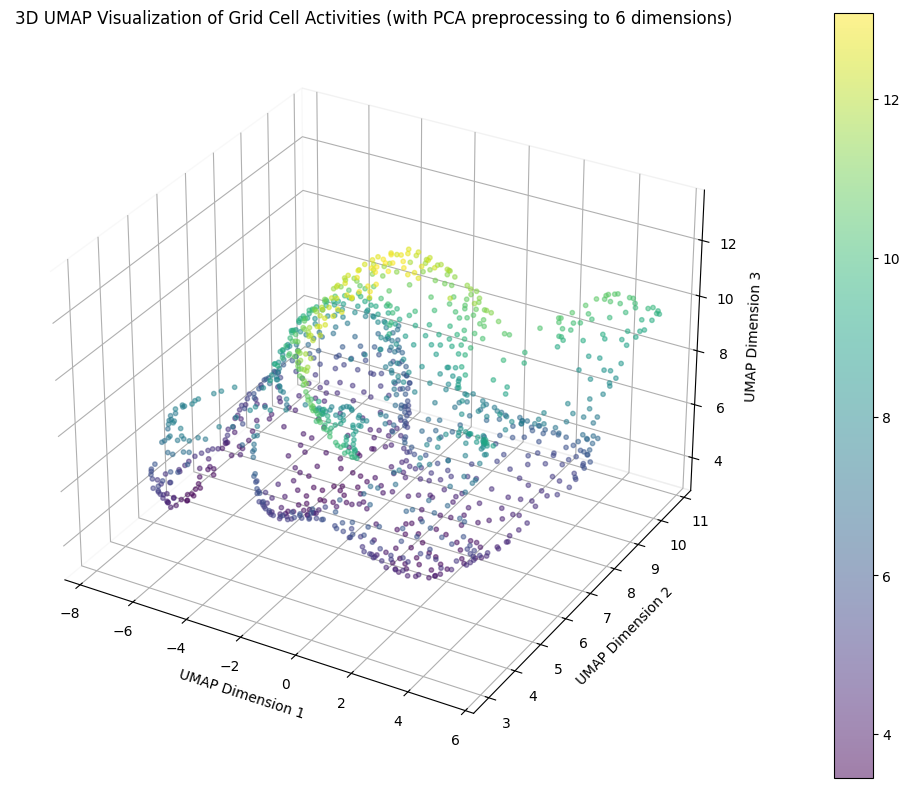

In [39]:
from visualize import visualize_umap_3d, create_interactive_3d_plot

def extract_central_square(rate_map, size_ratio=0.7):
    """Extract central square from each rate map to avoid edge artifacts"""
    res = int(np.sqrt(rate_map.shape[1]))
    center = res // 2
    half_size = int(res * size_ratio // 2)
    
    indices_i = np.arange(center - half_size, center + half_size)
    indices_j = np.arange(center - half_size, center + half_size)
    
    grid_i, grid_j = np.meshgrid(indices_i, indices_j)
    indices = np.ravel_multi_index((grid_i.flatten(), grid_j.flatten()), (res, res))
    
    return rate_map[:, indices]

fig, ax, embedding = visualize_umap_3d(extract_central_square(rate_map).T, use_pca_first=True, pca_components=6, random_state=42)
interactive_fig = create_interactive_3d_plot(embedding)
interactive_fig.show()

# Playground

In [27]:
g.shape

(200000, 4096)

Explained variance: PC1=7.26%, PC2=6.01%, PC3=5.82%
Total explained variance: 19.09%


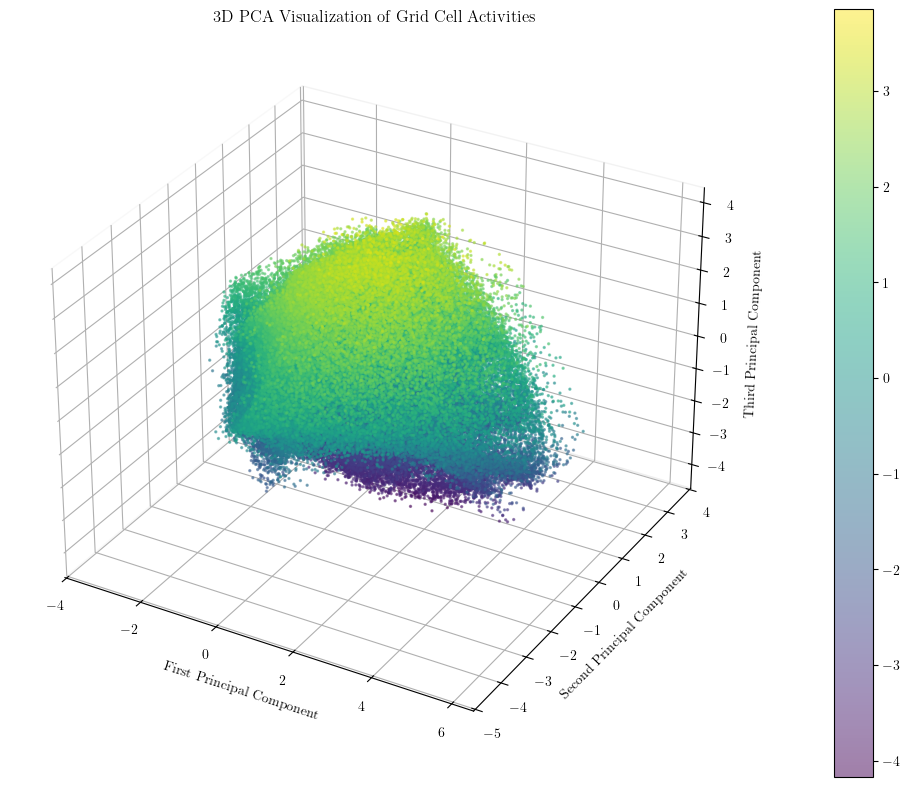

In [37]:
# Perform PCA and plot in 3D
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Extract 3 principal components instead of 2
pca = PCA(n_components=3)
g_transformed = pca.fit_transform(g)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create scatter plot with coloring by the third component
scatter = ax.scatter(
    g_transformed[:, 0], 
    g_transformed[:, 1], 
    g_transformed[:, 2],
    s=2,  # smaller point size
    alpha=0.5,
    c=g_transformed[:, 2],  # color by 3rd dimension
    cmap='viridis'
)

# Add colorbar and labels
plt.colorbar(scatter, ax=ax, pad=0.1)
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')
ax.set_title('3D PCA Visualization of Grid Cell Activities')

# Improve 3D visualization appearance
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(True)

# Print explained variance
explained_variance = pca.explained_variance_ratio_ * 100
print(f"Explained variance: PC1={explained_variance[0]:.2f}%, PC2={explained_variance[1]:.2f}%, PC3={explained_variance[2]:.2f}%")
print(f"Total explained variance: {sum(explained_variance):.2f}%")

plt.tight_layout()

In [27]:
g.shape

(200000, 4096)

In [66]:
# Extract central square from rate maps to minimize edge artifacts
def extract_central_square(rate_map, size_ratio=0.7):
    """Extract central square from each rate map to avoid edge artifacts"""
    res = int(np.sqrt(rate_map.shape[1]))
    center = res // 2
    half_size = int(res * size_ratio // 2)
    
    indices_i = np.arange(center - half_size, center + half_size)
    indices_j = np.arange(center - half_size, center + half_size)
    
    grid_i, grid_j = np.meshgrid(indices_i, indices_j)
    indices = np.ravel_multi_index((grid_i.flatten(), grid_j.flatten()), (res, res))
    
    return rate_map[:, indices]

In [28]:
g_sample = g[np.random.randint(0, g.shape[0], 5000)]

In [30]:
rate_map_lores.shape, rate_map.shape

((4096, 400), (4096, 2500))

In [69]:
extract_central_square(rate_map).shape, rate_map.shape

((4096, 1156), (4096, 2500))

Applying PCA to reduce dimensions from 4096 to 6...
Explained variance with 6 components: 51.45%
Applying UMAP to create 3D visualization...


/Users/julianyocum/anaconda3/envs/ganguli/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/julianyocum/anaconda3/envs/ganguli/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



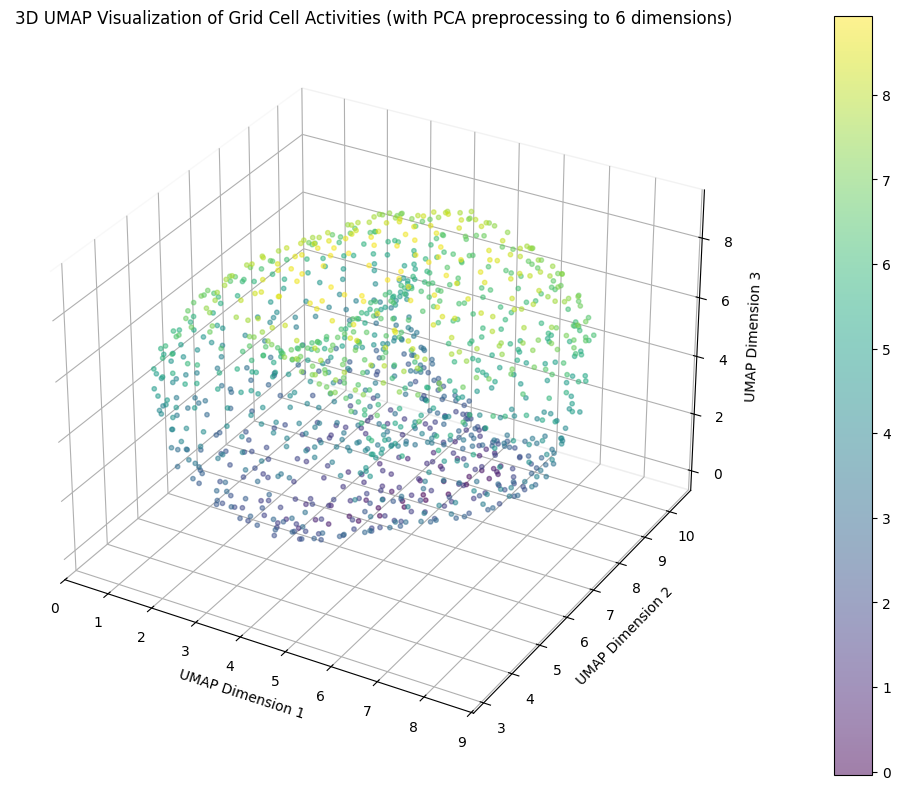

In [ ]:
from visualize import visualize_umap_3d

fig, ax, embedding = visualize_umap_3d(extract_central_square(rate_map).T, use_pca_first=True, pca_components=6, random_state=42)

In [78]:
# Create and display the interactive plot using the embedding we already calculated
interactive_fig = create_interactive_3d_plot(embedding)
interactive_fig.show()

Applying PCA to reduce dimensions from 4096 to 6...
Explained variance with 6 components: 32.43%
Applying UMAP to create 3D visualization...


/Users/julianyocum/anaconda3/envs/ganguli/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/julianyocum/anaconda3/envs/ganguli/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


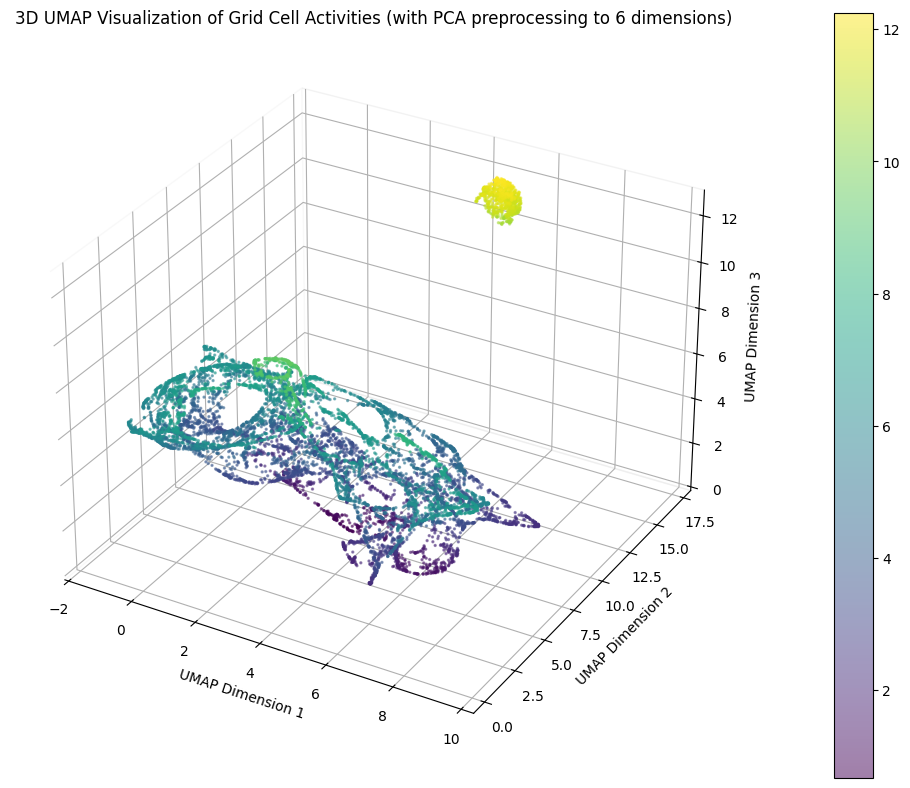

In [30]:
# sample of g
fig, ax, embedding = visualize_umap_3d(g_sample, use_pca_first=True, pca_components=6, random_state=42)

In [31]:
!pip install nbformat>=4.2.0 plotly

zsh:1: 4.2.0 not found


In [26]:
g.shape, rate_map.shape

((200000, 4096), (4096, 2500))

Applying PCA to reduce dimensions from 2500 to 6...
Explained variance with 6 components: 41.43%
Applying UMAP to create 3D visualization...


/Users/julianyocum/anaconda3/envs/ganguli/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/julianyocum/anaconda3/envs/ganguli/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


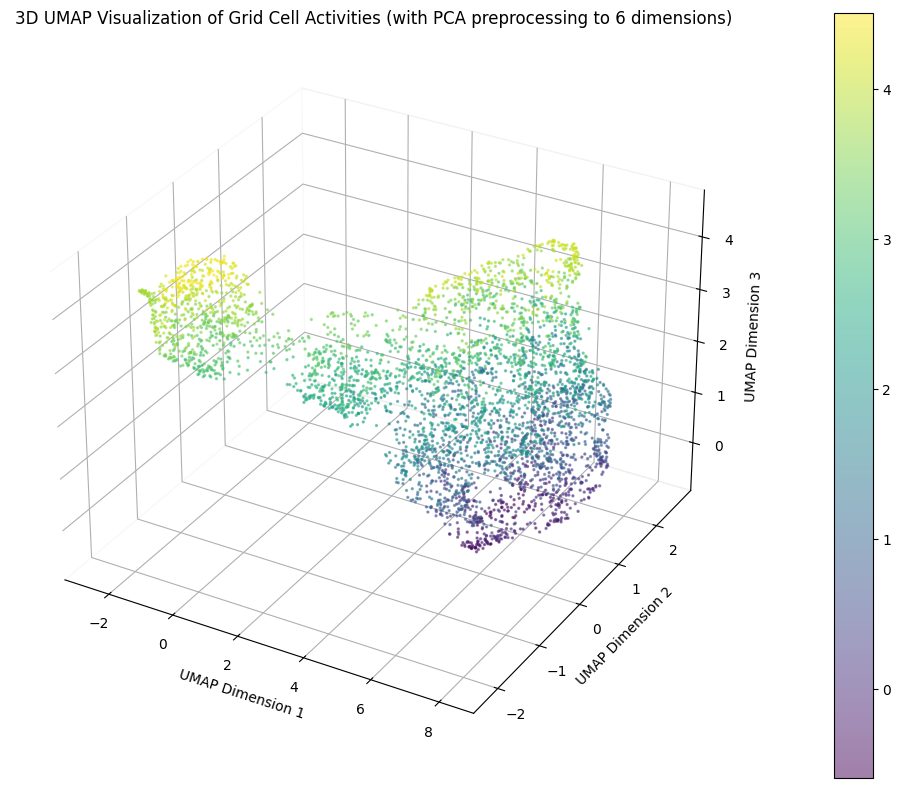

In [23]:
fig, ax, embedding = visualize_umap_3d(rate_map, use_pca_first=True, pca_components=6, random_state=42)

In [46]:
rate_map_lores.shape
top_n_rate_map = rate_map_lores[grid_sort[:200],:]
top_n_rate_map.shape

(200, 400)

In [29]:
rate_map_lores.shape, rate_map.shape, g_sample.shape

((4096, 400), (4096, 2500), (5000, 4096))

In [79]:
extract_central_square(rate_map).shape

(4096, 1156)

In [ ]:
# Persitent homology

# Persistent homology
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from ripser import ripser
from persim import plot_diagrams

# Extract central portion of rate maps
central_rate_map = extract_central_square(rate_map)
print(f"Original rate map shape: {rate_map.shape}, Central rate map shape: {central_rate_map.shape}")
# central_rate_map = g_sample

# PCA projection to reduce dimensionality (for computational efficiency)
pca_components = 7  # As suggested in the description
pca = PCA(n_components=pca_components)
rate_map_pca = pca.fit_transform(central_rate_map.T)
print(f"PCA projection shape: {rate_map_pca.shape}")
print(f"Explained variance: {np.sum(pca.explained_variance_ratio_) * 100:.2f}%")

# Create shuffled data for comparison (null model)
def shuffle_rate_maps(rate_map):
    """Shuffle each neuron's rate map independently"""
    shuffled = rate_map.copy()
    for i in range(shuffled.shape[0]):
        np.random.shuffle(shuffled[i])
    return shuffled

# Compute shuffled data
shuffled_rate_map = shuffle_rate_maps(central_rate_map)
shuffled_pca = PCA(n_components=pca_components)
shuffled_rate_map_pca = shuffled_pca.fit_transform(shuffled_rate_map.T)

# Compute persistent homology using Ripser
print("Computing persistent homology...")
result = ripser(rate_map_pca, maxdim=2, metric='cosine', coeff=47) # paper uses coeff=47
diagrams = result['dgms']

# Compute persistent homology on shuffled data
shuffled_result = ripser(shuffled_rate_map_pca, maxdim=2, metric='cosine', coeff=47)
shuffled_diagrams = shuffled_result['dgms']

# Plot the results
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
homology_dims = ['H₀ (Connected Components)', 'H₁ (1D Cycles)', 'H₂ (2D Holes)']

# Function to plot barcodes
def plot_barcode(ax, diagram, shuffled_diagram, title):
    # Sort by persistence (death - birth)
    persistence = diagram[:, 1] - diagram[:, 0]
    idx = np.argsort(-persistence)  # Sort by decreasing persistence
    
    # Handle infinity values for better visualization
    diagram_plot = diagram.copy()
    diagram_plot[diagram_plot[:, 1] == np.inf, 1] = diagram_plot[:, 0].max() * 1.2
    
    # Plot shuffled data as background
    if shuffled_diagram is not None:
        for i in range(min(20, len(shuffled_diagram))):  # Limit to 20 bars for clarity
            birth, death = shuffled_diagram[i]
            if death == np.inf:
                death = diagram_plot[:, 0].max() * 1.2
            ax.fill_betweenx([i, i+0.8], birth, death, color='beige', alpha=0.7)
    
    # Plot actual data
    for i, idx_i in enumerate(idx[:10]):  # Show top 10 features
        birth, death = diagram_plot[idx_i]
        ax.plot([birth, death], [i, i], 'navy', linewidth=2)
        
        # Add markers at ends
        ax.plot(birth, i, 'o', color='navy', markersize=4)
        ax.plot(death, i, '>', color='navy', markersize=4)
    
    ax.set_title(title)
    ax.set_ylabel("Feature")
    ax.set_xlabel("r")
    ax.grid(True, linestyle='--', alpha=0.7)

for i, (diagram, shuffled_diagram, title) in enumerate(zip(diagrams, shuffled_diagrams, homology_dims)):
    plot_barcode(axes[i], diagram, shuffled_diagram, title)

plt.tight_layout()
plt.show()

# Also show the persistence diagrams
plt.figure(figsize=(10, 8))
plot_diagrams(diagrams, show=True, lifetime=False)
plt.title("Persistence Diagrams")
plt.tight_layout()